# eqtl benchmark 4, post ace

First looking at alpha genome on the same benchmark

In [1]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import pandas as pd
import numpy as np
from scipy.spatial.distance import jensenshannon
import matplotlib.pyplot as plt

def predict_snp_effect_scores(ref_prob_preds, alt_prob_preds):
    """
    ref_prob_preds, alt_prob_preds: arrays of shape (N, L)
    returns five length-N arrays, with zeros for any row where both inputs are all-zero.
    """
    # 1) mask out rows where both ref & alt are entirely zero
    zero_mask = (ref_prob_preds.sum(axis=1) == 0) & (alt_prob_preds.sum(axis=1) == 0)
    valid    = ~zero_mask
    N        = ref_prob_preds.shape[0]
    
    # 2) prepare empty outputs
    logfc                    = np.zeros(N, dtype=float)
    log_probs_diff_abs_sum   = np.zeros(N, dtype=float)
    probs_jsd_diff           = np.zeros(N, dtype=float)
    integrative_effect_size  = np.zeros(N, dtype=float)
    integrative_effect_size2 = np.zeros(N, dtype=float)
    
    # 3) only compute on the valid rows
    if np.any(valid):
        r = ref_prob_preds[valid]
        a = alt_prob_preds[valid]
        
        # sum of absolute log-diffs
        lpd = np.sum(np.abs(np.log(a) - np.log(r)), axis=1)
        # Jensen-Shannon distance, one-by-one
        jsd = np.array([jensenshannon(x, y) for x,y in zip(a, r)])
        # log₂ fold-change of mean probabilities
        lf  = np.log2(r.mean(axis=1) / a.mean(axis=1))
        # two “integrative” sizes
        ies  = lf * jsd
        ies2 = lpd * jsd
        
        # 4) scatter them back into the full-size arrays
        log_probs_diff_abs_sum[valid]   = lpd
        probs_jsd_diff[valid]           = jsd
        logfc[valid]                    = lf
        integrative_effect_size[valid]  = ies
        integrative_effect_size2[valid] = ies2
    
    # 5) return—all-zero rows remain at zero
    return logfc, \
           log_probs_diff_abs_sum, \
           probs_jsd_diff, \
           integrative_effect_size, \
           integrative_effect_size2
           
def plot_metrics(out, labels, title):
    model_names = ['logfc', 'log_probs_diff_abs_sum', 'JSD', 'IED1', 'IED2']
    colors = ['blue', 'green', 'red', 'orange', 'purple']

    plt.figure(figsize=(6, 5))


    for i in range(len(model_names)):
        precision, recall, _ = precision_recall_curve(labels, np.abs(out[i]))
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, label=f'{model_names[i]} (AUC = {pr_auc:.3f})', color=colors[i])

    plt.title(title)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()

    plt.tight_layout()
    # plt.suptitle(title)
    plt.show()


qtls = pd.read_csv('/data1/lesliec/sarthak/data/joint_playground/eQTL/EPCOTv2_LCLs/LCLs.txt', sep=' ', header=None)
qtls.columns = ['label', 'qtl_idx', 'gene_idx', 'chrom', 'gene_start', 'gene_end', 'strand', 'qtl_loc', 'ref', 'alt', 'sign_target']
labels = qtls['label'].to_numpy()

def plot_selected_metric(files, labels, metric_name='logfc', sort_legend_by_auc=False, center=False, title='', mask=None):
    metric_index_map = {
        'logfc': 0,
        'log_probs_diff_abs_sum': 1,
        'JSD': 2,
        'IED1': 3,
        'IED2': 4
    }
    assert metric_name in metric_index_map, f"Invalid metric: {metric_name}"
    metric_idx = metric_index_map[metric_name]

    colors = ['blue', 'green', 'red', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

    plt.figure(figsize=(6, 5))
    legend_entries = []

    for i, file in enumerate(files):
        eqtl_data = np.load(f'/data1/lesliec/sarthak/data/joint_playground/eQTL/EPCOTv2_LCLs/{file}')
        if center:
            center_start = eqtl_data.shape[1] // 2 - center[i] // 2
            center_end = center_start + center[i]
            eqtl_data = eqtl_data[:, center_start:center_end, :]
        out = predict_snp_effect_scores(eqtl_data[:, :, 0], eqtl_data[:, :, 1])

        if mask is None: #can supply a mask or can use default mask of the first value!
            if i == 0:
                non_zero_mask = (out[0] != 0)
        else:
            non_zero_mask = mask

        selected_metric = np.abs(out[metric_idx])[non_zero_mask]
        precision, recall, _ = precision_recall_curve(labels[non_zero_mask], selected_metric)
        pr_auc = auc(recall, precision)

        line, = plt.plot(recall, precision, label=file, color=colors[i % len(colors)])
        legend_entries.append((pr_auc, line, f'{file} (AUC = {pr_auc:.3f})'))

    plt.title(f'Precision-Recall Curve for {metric_name} {title}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')

    if sort_legend_by_auc:
        legend_entries.sort(reverse=True, key=lambda x: x[0])  # sort by AUC descending
    handles = [entry[1] for entry in legend_entries]
    labels_sorted = [entry[2] for entry in legend_entries]

    plt.legend(handles, labels_sorted)
    plt.tight_layout()
    plt.show()
    
import pickle
base_dir = '/data1/lesliec/sarthak/data/joint_playground/eQTL/EPCOTv2_LCLs/'
with open(base_dir+'genes.pickle', 'rb') as f:
    gene_annotation = pickle.load(f)

ordered_genes = sorted(list(gene_annotation.keys()))

tmpgeneTSS = np.loadtxt(base_dir+'ensemblTSS.txt', dtype='str')
geneTSS_dic = {tmpgeneTSS[i, 0]: int(tmpgeneTSS[i, 1]) for i in range(tmpgeneTSS.shape[0])}

distances = np.zeros((qtls.shape[0],), dtype=int)

for i in range(qtls.shape[0]):
    #initialize values and load in data
    temp = qtls.iloc[i]
    chrom   = 'chrX' if temp['chrom']==23 else 'chr'+str(temp['chrom'])
    pos     = temp['qtl_loc'] - 1  # Convert to zero-based index
    gene_idx= temp['gene_idx']
    tss_loc = geneTSS_dic[ordered_genes[gene_idx]]
    # print(tss_loc, pos)
    distances[i] = abs(tss_loc - pos)

In [2]:
#let's first define a mask
import zarr
thresholds       = [1_000, 10_000, 524_288//2]
center = 16*128

auprc_by_threshold = []
for thr in thresholds:
    if thr == 1_000:
        mask = distances < thr
    elif thr == 10_000:
        mask = (distances >= 1_000) & (distances < thr)
    else:
        mask = (distances >= 10_000) & (distances < thr)
    
    row = []
    data = zarr.open('/data1/lesliec/sarthak/data/joint_playground/eQTL/EPCOTv2_LCLs/alphagenome_eqtl.zarr', mode='r')
    cs = data.shape[1] // 2 - center // 2
    ce = cs + center
    eqtl = data[:, cs:ce, :]
    out  = predict_snp_effect_scores(eqtl[:, :, 0], eqtl[:, :, 1])
    scores = np.abs(out[0])[mask]  # logFC metric
    pr, rc, _ = precision_recall_curve(labels[mask], scores)
    print(auc(rc, pr))
    # auprc_by_threshold.append(row)
# auprc = np.array(auprc_by_threshold)
# auprc

0.7069669531566851
0.757856943688386
0.5207397783542896


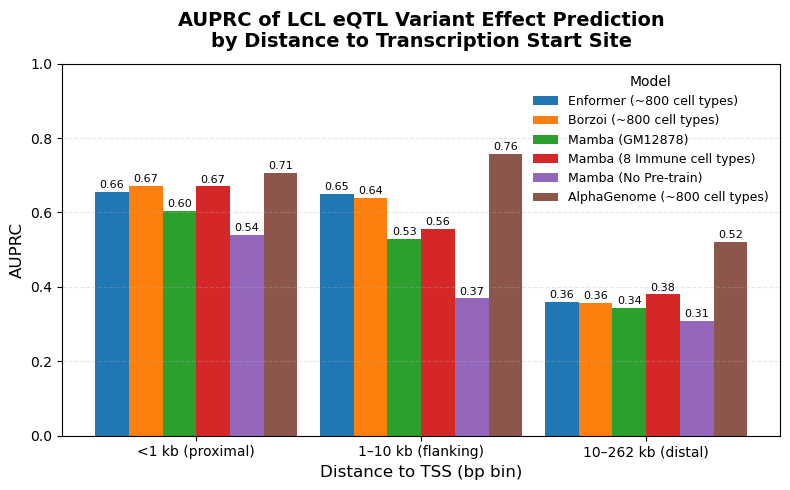

In [5]:
#lmfao it's so much better?!?????
files = ['enformer_eqtl.npy', 'borzoi_eqtl.npy', 'nomlm_maskonly.npy', 'immune.npy', 'nopretrain.npy', 'alphagenome_eqtl.zarr']

center = [16, 16*4, 16, 16, 16, 16*128]
threshold_names  = ['<1 kb (proximal)', '1–10 kb (flanking)', '10–262 kb (distal)']
model_files      = files
model_labels     = ['Enformer (~800 cell types)', 'Borzoi (~800 cell types)', 'Mamba (GM12878)',
                    'Mamba (8 Immune cell types)', 'Mamba (No Pre-train)', 'AlphaGenome (~800 cell types)']


auprc_by_threshold = []
for thr in thresholds:
    if thr == 1_000:
        mask = distances < thr
    elif thr == 10_000:
        mask = (distances >= 1_000) & (distances < thr)
    else:
        mask = (distances >= 10_000) & (distances < thr)

    row = []
    for i, fname in enumerate(model_files):
        if 'zarr' in fname:
            data = zarr.open(f'/data1/lesliec/sarthak/data/joint_playground/eQTL/EPCOTv2_LCLs/{fname}', mode='r')
        else:
            data = np.load(f'/data1/lesliec/sarthak/data/joint_playground/eQTL/EPCOTv2_LCLs/{fname}')
        cs = data.shape[1] // 2 - center[i] // 2
        ce = cs + center[i]
        eqtl = data[:, cs:ce, :]
        out  = predict_snp_effect_scores(eqtl[:, :, 0], eqtl[:, :, 1])
        scores = np.abs(out[0])[mask]  # logFC metric
        pr, rc, _ = precision_recall_curve(labels[mask], scores)
        row.append(auc(rc, pr))
    auprc_by_threshold.append(row)
auprc = np.array(auprc_by_threshold)  # shape (3,5)

# --- plotting ---
x         = np.arange(len(thresholds))
bar_width = 0.15

plt.figure(figsize=(8, 5))
for i, label in enumerate(model_labels):
    plt.bar(x + i*bar_width,
            auprc[:, i],
            width=bar_width,
            label=label)

# Annotate bar heights
for i in range(len(thresholds)):
    for j in range(len(model_labels)):
        y = auprc[i, j]
        plt.text(x[i] + j*bar_width, y + 0.005,
                 f'{y:.2f}', ha='center', va='bottom', fontsize=8)

# Styling
plt.xticks(x + (len(model_labels)-1)/2*bar_width, threshold_names, fontsize=10)
plt.yticks(fontsize=10)
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.xlabel('Distance to TSS (bp bin)', fontsize=12)
plt.ylabel('AUPRC', fontsize=12)
plt.title('AUPRC of LCL eQTL Variant Effect Prediction\nby Distance to Transcription Start Site', 
          fontsize=14, fontweight='bold', pad=12)

# leg = plt.legend(title='Model', fontsize=9, title_fontsize=10,
#                  bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)
leg = plt.legend(title='Model', fontsize=9, title_fontsize=10, loc='upper right', frameon=False)

plt.tight_layout()
plt.show()

In [4]:
#so a few major questions, one is it because they predicted and trained on base pair resolution? If so we can do the same!